In [1]:
import numpy as np
from epi_models import *
from eulerverfahren import *
from matplotlib import pyplot as plt
from utils import *
import os
import shutil
from matplotlib.animation import FuncAnimation
from IPython.display import display, Latex
%matplotlib widget

## Hinweis:
<font size="3">Für dieses Notebook genügt es, nacheinander den Code aller Zellen auszuführen. Es ist nicht notwendig, weitere Einstellungen vorzunehmen.

## ====== Experimentkonfiguration ======
<font size="3">Die folgende Experimentkonfiguration entspricht der Basiskonfiguration des Kapitels 5.2 *Reaktion und Diffusion* ergänzt um $D=4\times10^{-5}$ und $h=\frac{1}{128}$ als Diffusionskoeffizient bzw. Gitterweite.

In [2]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ~~~~~ Bevölkerungsstruktur ~~~~~
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Bevölkerungsgröße
N = 1e7    

# Besiedeltes Gebiet (Annahme: quadratisch)
X = 1    
Y = 1    
h = 1/2**7                         # Gitterweite
Nx, Ny = int(X/h+1), int(Y/h+1)    # Nx x Ny: Anzahl diskreter Gitterpunkte
assert Nx == Ny                    


# Bevölkerungsdichte
f_N = N/(Nx*Ny) * np.ones((Nx,Ny))

# Blutgruppen
f_B = get_blutgruppenverteilung()    # Anteile der Blutgruppen AB, A, B und 0
Nb = f_B.shape[0]                    # Anzahl an Blutgruppen

# Altersgruppen
f_A = get_altersverteilung()         # Anteile der Altersklassen 0-4Jahre, 5-9Jahre, ...., 80+ Jahre
Na = f_A.shape[0]                    # Anzahl an Altersgruppen

# Kombinierte Verteilungen
f_AB = np.tensordot(f_A,f_B, axes=0)       # Verteilung Altersklasse x Blutgruppe
f_NAB = np.tensordot(f_AB, f_N, axes=0)    # Verteilung Altersklasse x Blutgruppe x x-Koordinate x y-Koordinate

In [3]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ~~~~~~~~ Modellparameter ~~~~~~~~
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Skalierte Kontraktrate Lambda
# 1) Kontaktmatrix kappa
kappa = get_contact_matrix(a=1)                        # Kontaktmatrix: kappa_muster
# 2) Wahrscheinlichkeitsmatrix beta
b = 0.03                                               # Basiswahrscheinlichkeit einer Ansteckung bei Kontakt
delta = 0.4                                            # Wahrscheinlichkeitsreduktion bei Inkompatibilität nach dem AB0-Blutgruppensystem
beta = get_prob_matrix(b,delta,f_B)                    # Wahrscheinlichkeitsmatrix: beta_inhomo
# 1) + 2) => Skalierte Kontaktrate
lamda, lamda_scaled = get_lamda(kappa, beta, f_B, f_NAB)      # Skalierte Kontakrate: lambda       

# Genesungsrate Gamma
gamma = 1.0 / np.array([6]*Na)  

# Diffusionskoeffizient
D = 4e-5

In [4]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ~~~~~~~~~ Anfangswerte ~~~~~~~~~
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Anfangswert für das Kompartiment der Infizierten
# Zu Beginn ist genau ein Individuum aus Altersklasse 25-29 Jahre mit Blutgruppe A infiziert.
I0 = np.zeros((Na,Nb,Nx,Ny)) 
I0[5,1, Nx//2, Ny//2] = 1  

# Anfangswert für das Kompartiment der Suszeptiblen
S0 = f_NAB - I0

# Kombiniert
A0 = np.stack((S0,I0))

In [5]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ~~~~~~~~~ Zeitdiskretisierung ~~~~~~~~~
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

T = 300    # Einheit Tage
Nt = T*32   # (Nt+1) viele Zeitpunkte werden berechnet

In [6]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ~~~~~~~~~ Konfiguration des rangadaptiven Eulerverfahrens ~~~~~~~~~
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Hierarchischer Rang
max_rank_k = 1000    # Der max. hier. Rang ist so gewählt, dass er keine Einschränkung darstellt             
max_rank_r = 1000    # Der max. hier. Rang ist so gewählt, dass er keine Einschränkung darstellt 

# Konstanten
M1 = 1e-1
M2 = 1e-1

# Resultierende Fehlertoleranzen
eps_k = (M2 * (T/Nt)**2)/2    
eps_r = (M1 * (T/Nt))/4       

In [7]:
# Übersicht
print("~~~ Betrachtetes Gebiet ~~~")
print("Fläche des besiedelten Gebiets: {}".format(X*Y))
print("Besiedeltes Gebiet: [0,{}] x [0,{}]".format(X,Y))
print("Raumschrittweite (in x- und y-Richtung): {}".format(h))
print("Anzahl Gitterpunkte: {}x{}={}".format(Nx,Ny,Nx*Ny))
print("~~~ Population ~~~")
print("Populationsgröße: ", N)
print("Anzahl Altersklassen: ", Na)
print("Altersklassenverteilung: ", f_A)
print("Anzahl Blutgruppen: ", Nb)
print("Blutgruppenverteilung: ", f_B)
print("Diskrete Bevölkerungsdichte (homogen): {} Personen/Gitterpunkt".format(round(f_N[0,0])))
print("~~~ Parameter ~~~")
print("~ Reaktion ~")
print("Kontakte rein zufällig: ", np.allclose(np.repeat(f_A[:,None], Na, 1), kappa / (np.sum(kappa, axis=0))[:,None]))
print("Ansteckung unabhänhig von Blutgruppen: ", np.allclose(beta, beta[0,0]))
print("Genesung unabhängig von Alter: ", np.allclose(gamma, gamma[0]))
print("Tägliche Kontakte pro Individuum: ", np.sum(f_A*np.sum(kappa,axis=0)))
print("Gemittelte Ansteckungswahrscheinlichkeit bei Kontakt: ", np.sum(f_B * np.sum(f_B[None,:] * beta, axis=1)))
print("Gemittelte skalierte Kontaktrate: ", np.tensordot(f_AB, np.sum(lamda_scaled, axis=(0,1))))
print("Gemittelte unskalierte Kontaktrate: ", np.tensordot(f_AB, np.sum(lamda, axis=(0,1))))
print("Gemittelte Genesungsrate: ", np.sum(f_A*gamma))
print("Gemittelte Kontaktzahl: ", np.tensordot(f_AB, np.sum(lamda/gamma[None,None:,None], axis=(0,1))))
print("~ Diffusion ~")
print("Diffusionskoeffizient: {}".format(D))
print("~~~ Zeit ~~~")
print("Zeitintervall: [0,{}]".format(T))
print("tau: {}".format(T/Nt))
print("(tau*D)/h^2: ", (T/Nt*D)/h**2)
print("~~~ HTucker ~~~")
print("Fehlerschranke eps_k: ", eps_k)
print("Fehlerschranke eps_r: ", eps_r)

~~~ Betrachtetes Gebiet ~~~
Fläche des besiedelten Gebiets: 1
Besiedeltes Gebiet: [0,1] x [0,1]
Raumschrittweite (in x- und y-Richtung): 0.0078125
Anzahl Gitterpunkte: 129x129=16641
~~~ Population ~~~
Populationsgröße:  10000000.0
Anzahl Altersklassen:  17
Altersklassenverteilung:  [0.04728 0.04825 0.04587 0.04661 0.0537  0.05947 0.06616 0.06531 0.06298
 0.05785 0.0705  0.08131 0.07353 0.06021 0.05122 0.03729 0.07246]
Anzahl Blutgruppen:  4
Blutgruppenverteilung:  [0.05 0.43 0.11 0.41]
Diskrete Bevölkerungsdichte (homogen): 601 Personen/Gitterpunkt
~~~ Parameter ~~~
~ Reaktion ~
Kontakte rein zufällig:  False
Ansteckung unabhänhig von Blutgruppen:  False
Genesung unabhängig von Alter:  True
Tägliche Kontakte pro Individuum:  9.477345600148999
Gemittelte Ansteckungswahrscheinlichkeit bei Kontakt:  0.03
Gemittelte skalierte Kontaktrate:  0.03348947475369884
Gemittelte unskalierte Kontaktrate:  0.2843203680044701
Gemittelte Genesungsrate:  0.16666666666666669
Gemittelte Kontaktzahl:  1.70

##  ====== Modellinitialisierung ======

In [8]:
# Vorbereitung des Ergebnisverzeichnis
del_if_exists = True
experiment_name = "h={},tau={}D={},M1={},M2={}".format(h,T/Nt,D,M1,M2)
dirname_full = "ergebnisse\\Diffusion\\" + experiment_name + "\\full"
dirname_ht = "ergebnisse\\Diffusion\\" + experiment_name + "\\ht"
if os.path.isdir(dirname_full) and del_if_exists:
    shutil.rmtree(dirname_full)
if os.path.isdir(dirname_ht) and del_if_exists:
    shutil.rmtree(dirname_ht)

In [9]:
# Initilisierung beider Modelle

# Modell mit vollen Tensoren
model_full = ExtendedSIRModelFull(A0, lamda_scaled, gamma, D)
model_full.set_time_discretization(T, Nt)
model_full.set_space_discretization(X, Y, Nx, Ny)
model_full.set_population_settings(N, f_N, f_A, f_B, f_AB, f_NAB)
# Outputhandler für volles Modell
# Definiert welche der Informationen, die während der Simulation anfallen, gespeichert werden
oh_full = OutputHandler(path=".", dname=dirname_full, model=model_full, standard_output=True)
oh_full.prepare_dir()
oh_full.write_settings(model_full.__dict__)


# Modell mit vollen Tensoren
model_ht = ExtendedSIRModelHTucker(A0, lamda_scaled, gamma, D)
model_ht.set_time_discretization(T, Nt)
model_ht.set_space_discretization(X, Y, Nx, Ny)
model_ht.set_htucker_settings(mrs=max_rank_k, mrd=max_rank_r, aes=eps_k, aed=eps_r)
model_ht.truncate_A0()
model_ht.truncate_lamda()
model_ht.set_population_settings(N, f_N, f_A, f_B, f_AB, f_NAB)
# Outputhandler für volles Modell
# Definiert welche der Informationen, die während der Simulation anfallen, gespeichert werden
oh_ht = OutputHandler(path=".", dname=dirname_ht, model=model_ht, standard_output=True)
oh_ht.prepare_dir()
oh_ht.write_settings(model_ht.__dict__)

Typ:  <class 'numpy.int64'>


ValueError: 't' muss eine Liste nicht-negativer ints ohne Duplikate sein.

## ====== Simulationsberechnung ======

In [10]:
# Rangadaptives Eulververfahren
# HTucker Tensoren
RE = RangadaptivesEulerverfahren(model_ht, oh_ht)
RE.compute()


# Explizites Eulerverfahren
# Volle Tensoren
EE = ExplizitesEulerverfahren(model_full, oh_full)
EE.compute()

100%|██████████████████████████████████████████████████████████████████████████████| 9600/9600 [25:58<00:00,  6.16it/s]


## ====== Auswertung ======

### 1) Auswahl des Experiments, dessen Lösung betrachtet werden soll

In [11]:
# Wahl, welche Lösung ausgewertet werden soll
# Für dieses Notebook ist dabei D=4e-5 und h=1/128 fix 
# tau, M1 und M2 können je nach vorhandenen Lösungen gewählt werden
tau = 1/32
M1 = 1e-1
M2 = 1e-1
# Die Namen der Lösungsverzeichnissse ergeben sich damit wie folgt:
experiment_name = "h={},tau={}D={},M1={},M2={}".format(1/128, tau, 4e-5, M1, M2)
dirname_EE = "ergebnisse\\Diffusion\\" + experiment_name + "\\full"
dirname_RE = "ergebnisse\\Diffusion\\" + experiment_name + "\\ht"

# Einladen der Experimentkonfiguration für beide Lösungsverfahren
# (Explizites Eulerverfahren und rangadaptives Eulerverfahren)
konf_EE = load(os.path.join(dirname_EE, "settings.txt"))
konf_RE = load(os.path.join(dirname_RE, "settings.txt"))
# Prüfe, ob EE und RE auf selben Einstellungen beruhen
assert {k:v for k,v in konf_EE.items() if k != "lamda"} == {k:v for k,v in konf_EE.items() if k != "lamda"}
assert np.allclose(konf_EE["lamda"], konf_RE["lamda"], atol=0.08)
T, N, f_N, Ny, Nx = konf_EE["T"], konf_EE["N"], konf_EE["f_N"], konf_EE["Y"]//konf_EE["h"], konf_EE["X"]//konf_EE["h"]
X, Y = konf_EE["Y"], konf_EE["X"]

# Die beiden folgenden Listen enthalten die Dateinamen
# der ausgewählten Lösung (explizites Eulerverfahren)
# in zeitlich aufsteigender Reihenfolge: S0, S1, ... bzw. I0, I1,...
S_EE = [os.path.join(dirname_EE, "S","S_t{}.npy").format(round(item)) for item in np.arange(T+1)]
I_EE = [os.path.join(dirname_EE, "I","I_t{}.npy").format(round(item)) for item in np.arange(T+1)]

# Die beiden folgenden Listen enthalten die Dateinamen
# der ausgewählten Lösung (rangadaptives Eulerverfahren)
# in zeitlich aufsteigender Reihenfolge: S0, S1, ... bzw. I0, I1,...
S_RE = [os.path.join(dirname_RE, "S","S_t{}.pkl").format(round(item)) for item in np.arange(T+1)]
I_RE = [os.path.join(dirname_RE, "I","I_t{}.pkl").format(round(item)) for item in np.arange(T+1)]

### 2) Makroskopischer Verlauf: RE vs. EE

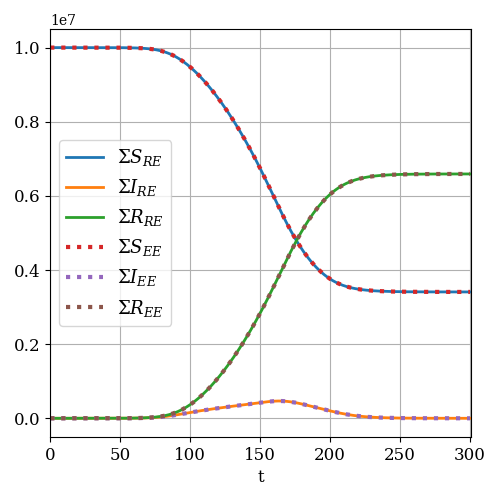

In [12]:
# Verlauf der Epidemie summiert über alle Altersklassen, Blutgruppen und Ortspunkte

# Plot
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.close("all")
xaxis = np.arange(len(I_EE))
fig, axes = plt.subplots(nrows = 1, ncols=1, figsize=(5, 5))
ax0 = axes
# Axis 0
ax0.plot(xaxis, [np.sum(load_single_htucker(name).full()) for name in S_RE], label="$\Sigma S_{RE}$",linewidth=2)
ax0.plot(xaxis, [np.sum(load_single_htucker(name).full()) for name in I_RE], label="$\Sigma I_{RE}$",linewidth=2)
ax0.plot(xaxis, [N - np.sum(load_single_htucker(S_RE[i]).full()) - np.sum(load_single_htucker(I_RE[i]).full()) for i in range(len(S_RE))], label="$\Sigma R_{RE}$",linewidth=2)
ax0.plot(xaxis, [np.sum(load_single_array(name), axis=(0,1,2,3)) for name in S_EE], label="$\Sigma S_{EE}$", linestyle="dotted", linewidth=3)
ax0.plot(xaxis, [np.sum(load_single_array(name), axis=(0,1,2,3)) for name in I_EE], label="$\Sigma I_{EE}$", linestyle="dotted", linewidth=3)
ax0.plot(xaxis, [N-np.sum(load_single_array(S_EE[i])+load_single_array(I_EE[i]),axis=(0,1,2,3)) for i in range(len(S_EE))]
                 , label="$\Sigma R_{EE}$", linestyle="dotted", linewidth=3)
ax0.set_xlabel("t", fontsize=12)
ax0.grid()
ax0.set_xlim(0,len(I_EE))
ax0.legend(fontsize=13)
ax0.tick_params(axis='both', which='major', labelsize=12)
fig.tight_layout(pad=1.0)

### 3) Speicherbedarf: RE vs. EE

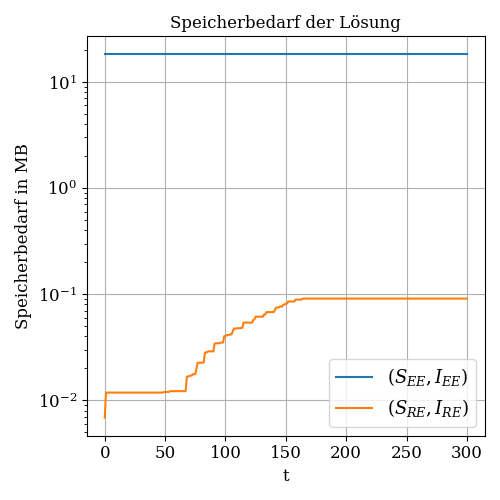

In [13]:
# Speicherbedarf

# Plot
fig, axes = plt.subplots(nrows = 1, ncols=1, figsize=(5, 5))
x_axis = np.arange(len(S_RE))
axes.plot(x_axis, [load_single_array(S_EE[i]).nbytes/1e6 + load_single_array(I_EE[i]).nbytes/1e6 for i in range(len(S_EE))], label="$(S_{EE},I_{EE})$")
axes.plot(x_axis, [load_single_htucker(S_RE[i]).get_size()/1e6 + load_single_htucker(I_RE[i]).get_size()/1e6 for i in range(len(S_RE))], label="$(S_{RE},I_{RE})$")
axes.legend(fontsize=13)
axes.grid()
axes.tick_params(axis='both', which='major', labelsize=12)
axes.set_ylabel("Speicherbedarf in MB", fontsize=12)
axes.set_xlabel("t", fontsize=12)
axes.set_yscale("log")
axes.set_title("Speicherbedarf der Lösung")
fig.tight_layout()

### 4) Räumliche Ausbreitung Animation: RE

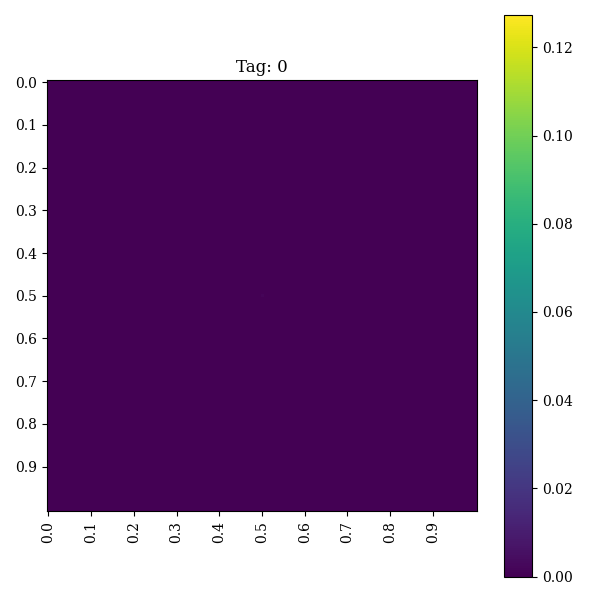

In [100]:
# Datenvorbereitung
I_spatial = [np.sum(load_single_htucker(fname).full(), axis=(0,1))/np.array(f_N) for fname in I_RE]
# Animation
plt.close("all")
plt.rcParams["figure.figsize"] = [6, 6]
plt.rcParams["figure.autolayout"] = True

fig = plt.figure()
plot = plt.imshow(I_spatial[0], vmax=np.max(I_spatial)*1.2, vmin=0.0)
ax = plt.gca()
ax.set_title("Tag: {}".format(0))
ax.set_yticks(np.arange(0,Ny,Ny/10), np.round(np.arange(0,Y,0.1),1), fontsize=12)
ax.set_xticks(np.arange(0,Nx,Nx/10), np.round(np.arange(0,X,0.1),1), fontsize=12,rotation=90)
fig.colorbar(plot, ax=ax) 

def init():
    plot.set_data(I_spatial[0])

    return plot
def animate(i):
    plot.set_data(I_spatial[i])
    ax.set_title('Tag: {}'.format(i))
    return [plot]

anim = FuncAnimation(fig, animate, init_func=init, frames=len(I_spatial), blit=True, interval=125, repeat=False)

In [49]:
anim.event_source.stop()
plt.close()

### 4) Räumliche Ausbreitung: RE vs. EE

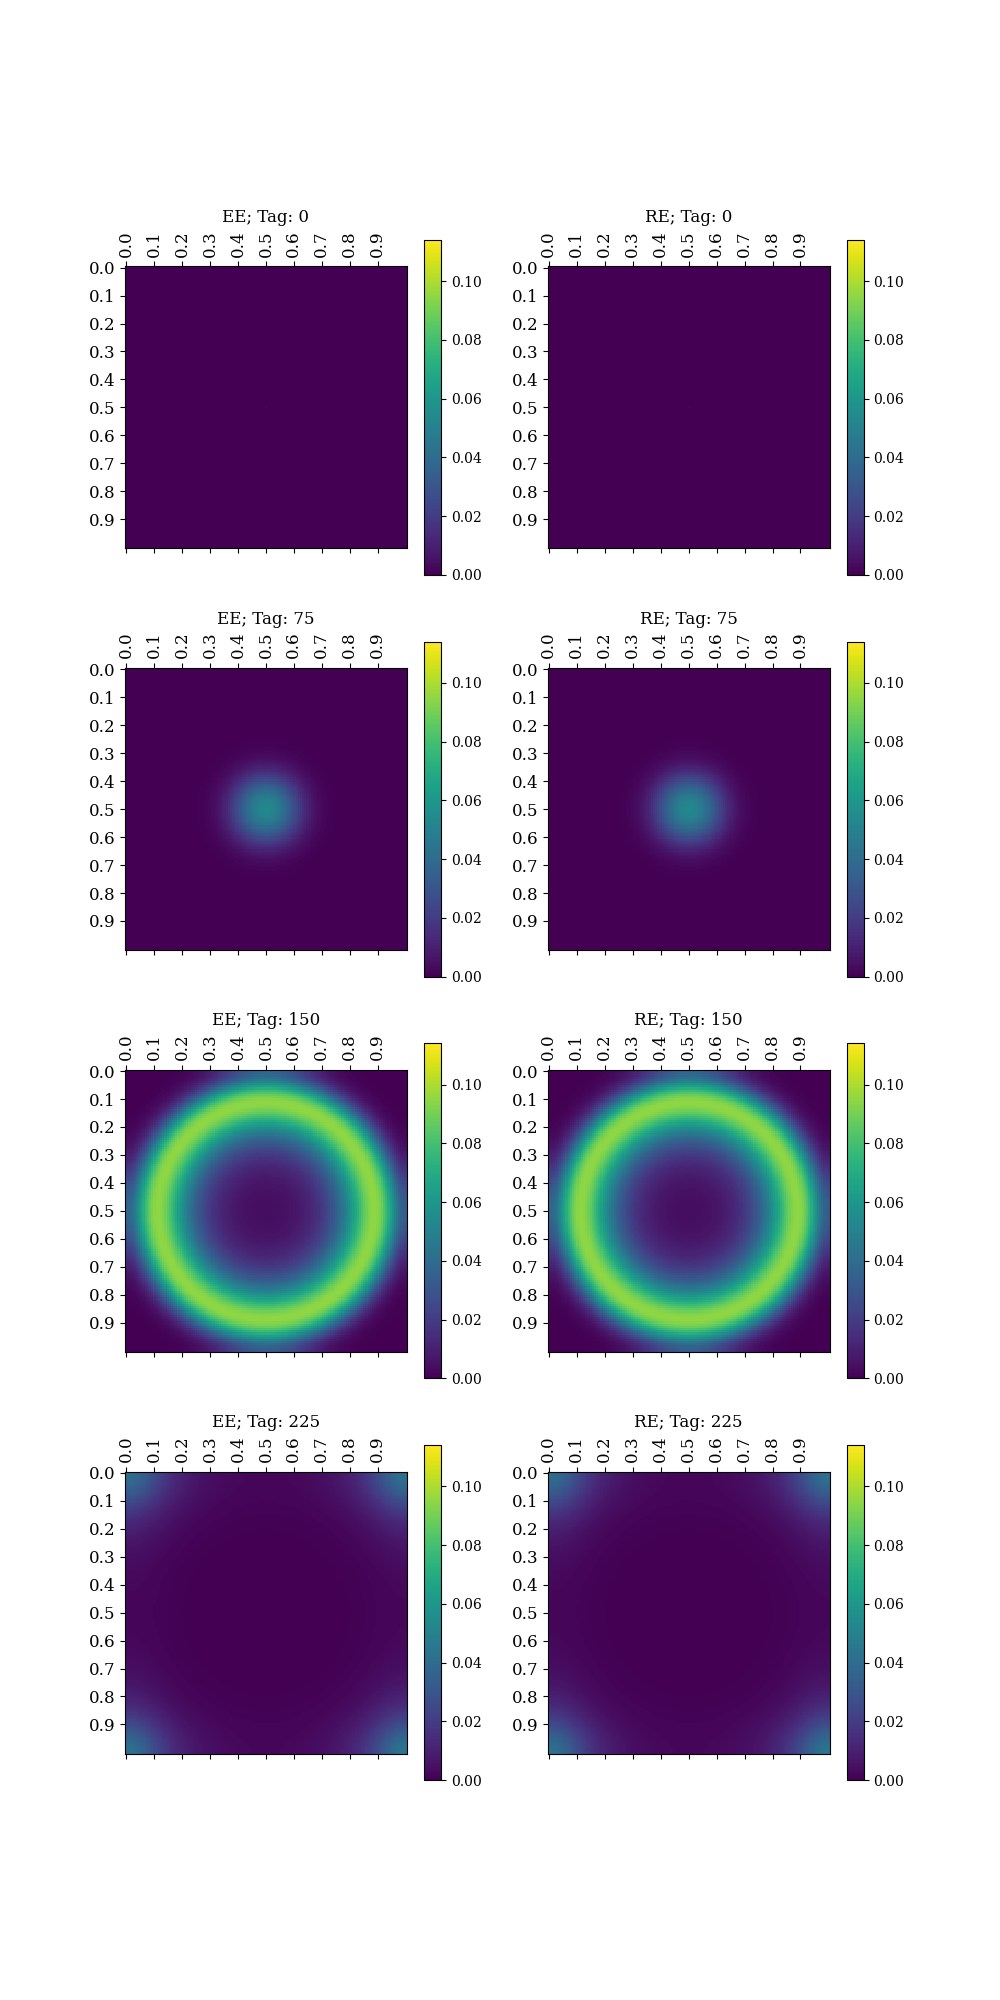

In [15]:
# Räumliche Ausbreitung

# Datenvorbereitung
days = list(np.arange(4)*75)
I_spatial_EE = [np.sum(load_single_array(fname),axis=(0,1))/f_N for fname in [I_EE[day] for day in days]]
I_spatial_RE = [np.sum(load_single_htucker(fname).full(), axis=(0,1))/f_N for fname in [I_RE[day] for day in days]]

# Plot
plt.close("all")
fig, axes = plt.subplots(nrows = 4, ncols=2, figsize=(5*2, 5*4))
for idx, ax in enumerate(axes):
    axl, axr = ax
    day = days[idx]
    if idx >= len(I_spatial_EE):
        continue
    iml = axl.matshow(I_spatial_EE[idx], vmax=np.max(I_spatial_EE)*1.2, vmin=0.0)
    axl.set_title("EE; Tag: {}".format(day))
    axl.set_yticks(np.arange(0,Ny,Ny/10), np.round(np.arange(0,Y,0.1),1), fontsize=12)
    axl.set_xticks(np.arange(0,Nx,Nx/10), np.round(np.arange(0,X,0.1),1), fontsize=12,rotation=90)
    fig.colorbar(iml, ax=axl) 
    imr = axr.matshow(I_spatial_RE[idx], vmax=np.max(I_spatial_RE)*1.2, vmin=0.0)
    axr.set_title("RE; Tag: {}".format(day))
    axr.set_yticks(np.arange(0,Ny,Ny/10), np.round(np.arange(0,Y,0.1),1),fontsize=12)
    axr.set_xticks(np.arange(0,Nx,Nx/10), np.round(np.arange(0,X,0.1),1), rotation=90,fontsize=12)
    fig.colorbar(imr, ax=axr) 

### 5) epsilon-Vergleich: RE vs. EE

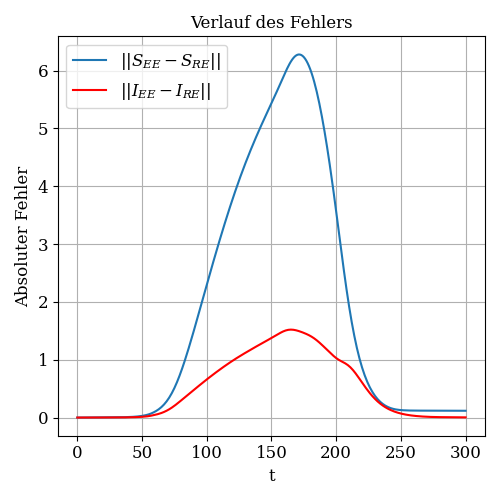

In [16]:
# Verlauf des Fehlers zwischen der Lösung mit vollen Tensoren und der Lösung mit hierarchischen Tuckertensoren

# Datenaggregation
abs_err_S = [np.linalg.norm(load_single_array(S_EE[i])-load_single_htucker(S_RE[i]).full()) for i in range(len(S_RE))]
abs_err_I = [np.linalg.norm(load_single_array(I_EE[i])-load_single_htucker(I_RE[i]).full()) for i in range(len(I_RE))]

# Plot
fig, axes = plt.subplots(nrows = 1, ncols=1, figsize=(5, 5))
ax1 = axes
xaxis = np.arange(len(abs_err_S))
ax1.plot(xaxis, abs_err_S, label="$||S_{EE}-S_{RE}||$")
ax1.plot(xaxis, abs_err_I, label="$||I_{EE}-I_{RE}||$", color="red")
ax1.legend(fontsize=13)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.grid()
ax1.set_xlabel("t", fontsize=12)
ax1.set_title("Verlauf des Fehlers")
ax1.set_ylabel("Absoluter Fehler", fontsize=12)
ax1.legend(fontsize=12)
fig.tight_layout()

### 6) Hiearchische Ränge: RE

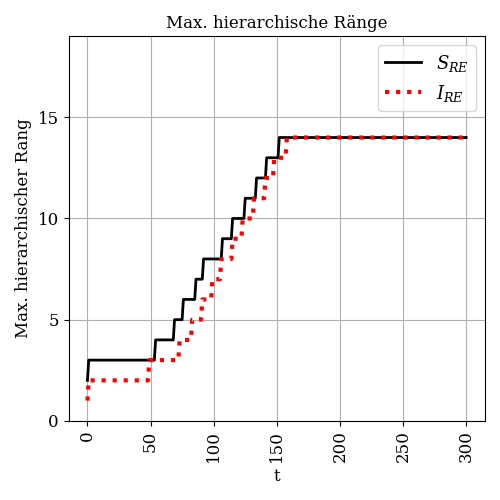

In [17]:
# Verlauf der maximalen hierarchischen Ränge

# Datenvorbereitung
Rank = {"S": [max(load_single_htucker(fname).rank.values()) for fname in S_RE]}
Rank["I"] = [max(load_single_htucker(fname).rank.values()) for fname in I_RE]
max_rank = max(max(Rank["S"]), max(Rank["I"]))

# Plot
fig, ax = plt.subplots(nrows = 1, ncols=1, figsize=(5, 5))
# Plot 1: Ränge
x_axis = np.arange(len(S_RE))
ax.plot(x_axis, Rank["S"], label="$S_{RE}$", linewidth=2, color="black")
ax.plot(x_axis, Rank["I"], label="$I_{RE}$", linestyle="dotted", linewidth=3, color="red")
ax.legend(fontsize=13)
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_ylabel("Max. hierarchischer Rang", fontsize=12)
ax.set_ylim([0,max_rank+5])
ax.set_yticks(np.arange(0,max_rank+5, 5), np.arange(0,max_rank+5,5))
ax.set_xticks(np.arange(0,len(S_RE),50), np.arange(0,len(S_RE),50), rotation=90)
ax.set_xlabel("t", fontsize=12)
ax.set_title("Max. hierarchische Ränge")
fig.tight_layout()